# Creating a truth table for Toffoli gate by sampling

## Create a Toffoli gate

In [ ]:
from quri_parts.circuit import QuantumCircuit
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_parts.core.state import ComputationalBasisState
from quri_parts.circuit.utils.circuit_drawer import draw_circuit

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

n_qubits = 3
circuit = QuantumCircuit(n_qubits)
circuit.add_TOFFOLI_gate(0, 1, 2)

draw_circuit(circuit)

        
        
----●---
    |   
    |   
    |   
----●---
    |   
   _|_  
  |TOF| 
--|0  |-
  |___| 


## Sample all possible initial states and create a truth table

In [ ]:
def generate_truthtable(circuit, sampler, shots=1000):
    """
    Generates a truth table for a given quantum circuit using a specified sampler.

    Parameters:
    circuit (QuantumCircuit): The quantum circuit for which the truth table is generated.
    sampler (callable): A function that samples the given circuit.
    shots (int): The number of shots used for sampling (default is 1000).

    Returns:
    None
    """

    num_qubits = circuit.qubit_count
    total_states = 2**num_qubits  # Total number of initial states

    results_list = []

    for i in range(total_states):
        init_circuit = QuantumCircuit(num_qubits)
        state_circuit = ComputationalBasisState(num_qubits, bits=i).circuit
        state_circuit = init_circuit + state_circuit
        sample_circuit = state_circuit + circuit

        results_list.append(sampler(sample_circuit, shots=shots))

    # Prepare a dataframe to map initial states to sampled outcomes
    data = []

    for initial_state in range(total_states):
        row = {}
        for sampled_state in range(total_states):
            # Check the correspondence between initial state and sampled outcome to get counts
            count = results_list[sampled_state].get(initial_state, 0)
            row[f"{sampled_state:b}".zfill(n_qubits)] = count / shots
        data.append(row)

    # Create a dataframe
    df = pd.DataFrame(
        data, index=[f"{i:b}".zfill(n_qubits) for i in range(total_states)]
    )

    # Display heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap="viridis", fmt=".0f", cbar=True)

    plt.xlabel("Sampled State")
    plt.ylabel("Initial State")

    plt.show()

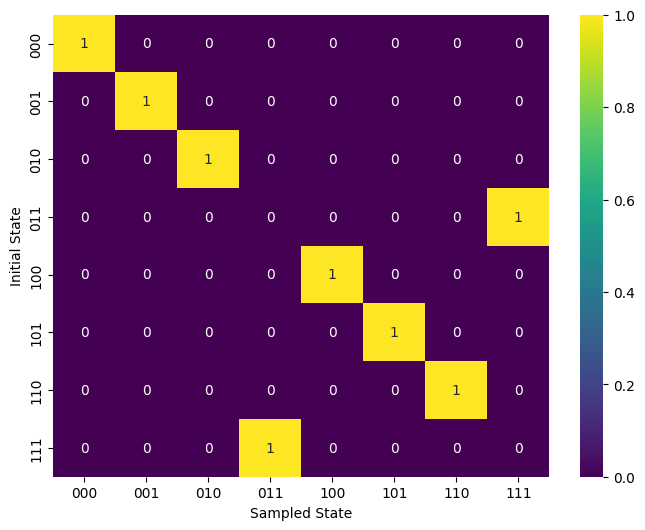

In [ ]:
# Create a sampler
shots = 1000
sampler = create_qulacs_vector_sampler()
# Get a list of sampling results for each possible quantum state.
results = generate_truthtable(circuit, sampler, shots)

##  Transpile a Toffoli gate into smaller gates

Here, we decompose the Toffoli gate into smaller gates using the `ParallelDecomposer`. Then, we verify its proper decomposition by drawing a truth table.

In [ ]:
from quri_parts.circuit.transpile import (
    TOFFOLI2HTTdagCNOTTranspiler,
    H2RZSqrtXTranspiler,
    T2RZTranspiler,
    Tdag2RZTranspiler,
    SequentialTranspiler,
    ParallelDecomposer,
)

transpiler = SequentialTranspiler(
    [
        TOFFOLI2HTTdagCNOTTranspiler(),
        ParallelDecomposer(
            [
                H2RZSqrtXTranspiler(),
                T2RZTranspiler(),
                Tdag2RZTranspiler(),
            ]
        ),
    ]
)

n_qubits = 3
circuit = QuantumCircuit(n_qubits)
circuit.add_TOFFOLI_gate(0, 1, 2)

circuit = transpiler(circuit)

draw_circuit(circuit, line_length=120)

                                                                                           ___                  
                                                                                          |RZ |                 
--------------------------------------------●-------------------------------●-------●-----|16 |-----●-----------
                                            |                               |       |     |___|     |           
                                            |                      ___      |      _|_     ___     _|_          
                                            |                     |RZ |     |     |CX |   |RZ |   |CX |         
----------------------------●---------------|---------------●-----|10 |-----|-----|15 |---|17 |---|18 |---------
                            |               |               |     |___|     |     |___|   |___|   |___|         
   ___     ___     ___     _|_     ___     _|_     ___     _|_     ___     _|_     ___     ___  

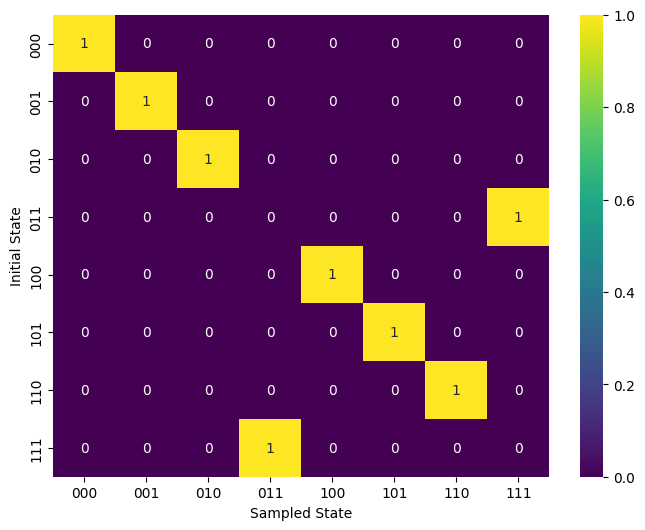

In [ ]:
# Create a sampler
shots = 1000
sampler = create_qulacs_vector_sampler()
# Get a list of sampling results for each possible quantum state.
results = generate_truthtable(circuit, sampler, shots)